In [1]:
import pandas as pd
import numpy as np
import os
import math
import random

os.makedirs('lscour_calcs', exist_ok=True)

# From Trampush et al., 2014
Trampush_velocities = {
    '50':1.2843137254901962,
    '25':0.8413867822318526,
    '75':1.6939077776156426
}

a0 = -2.08
a1 = 0.254
a2 = -1.09

D50_trampush = lambda Hbf, slope: np.exp((np.log10(slope) - a0 - (a2 * np.log10(Hbf)))/a1) # invert for D50 (mm)

seconds_in_month = 2629800

R = 1.65 # Submerged specific gravity for quartz
g = 9.81 # gravity

rho = 1000 # density of water (kg/m^3)
ps =  2650 # density of sediment (kg/m^3)
t_crit = 0.03 # critical shields stress

def estimate_tc(row):
    # Lamb et al., 2008
    return np.power(0.15*row['S [-]'], 0.25)
    
Hbf_Dunne = lambda S, tc, rho, g: (1.2*tc)/(rho*g*S)

def get_Hbf(row): # Choose randomly whether to use flow depth from Dunne and Jerolmack, 2018
    # using flow velocity
    
    if row['Hbf [m] (recorded)'] > 0:  
        
        return row['Hbf [m] (recorded)']
    
    else:
        
        hc_dunne = Hbf_Dunne(row['S [-]'], row['t_c_bank'], rho, g)
        hc_velocity = row['discharge [cms]']/row['U [m/s]']/row['Width [m]']

#         if random.randrange(0, 2, 1): # 1 = Velocity 0 = D & J
#             return hc_velocity
#         else:
#             return hc_dunne
        
        return hc_velocity

def tb_depth_slope(row):
    return rho*g*row['Hbf [m]']*row['S [-]']

def get_D50(row):
    if row['D50 [m] (recorded)'] > 0:
        return row['D50 [m] (recorded)']
    else:
        #D50_1 = float(D50_trampush(row['Hbf [m]'], row['S [-]']))/float(1000)
        D50_2 = (row['t_b']/(row['t_c']*(ps-rho)*g))
        return D50_2

def get_Cf(row):
    if row['Cf'] > 0:
        return row['Cf']
    else:
        #return (g*row['S [-]']*row['Hbf [m]'])/np.power(row['U [m/s]'], 2)
        return 0.01

def L_b(row):
    return row['Hbf [m]']/row['S [-]']/1000

# Ma et al., 2017 D50

def n_Ma(D50):
    # Ma et al. [2017] n exponent
    return (1.322 / (1 + np.exp(math.pow(10,5) * ((-1 * D50) + (1.6 * math.pow(10, -4))  )))) + 1.678
      
def a_Ma(D50):
    # Ma et al. [2017] alpha exponent
    return (0.859 / (1 + np.exp(math.pow(10,5) * (D50 - (1.6 * math.pow(10, -4))  )))) + 0.036

def Qs_Ma(row):
    a_ma_rep = a_Ma(row['D50 [m]'])
    n_ma_rep = n_Ma(row['D50 [m]'])        

    tau_star = ((row['Hbf [m]'])*row['S [-]'])/(R*row['D50 [m]'])

    qs_star = (a_ma_rep*np.power(tau_star, n_ma_rep))/row['Cf']
    qs = qs_star*np.sqrt(R*g*np.power(row['D50 [m]'],3))

    return qs*row['Width [m]']
    
def Qs(row):
    
#     if row['D50 [m] (recorded)']:        
#         return Qs_Ma(row)
#     else:
    if row['WBMSed Qs [kgs]'] > 0:   
        return row['WBMSed Qs [kgs]']/ps
    else:
        return Qs_Ma(row)
        

def t_scour(row):
    if row['Tscour [months]'] > 0:
        return row['Tscour [months]']
    else:
        return 1.7
    
def t_adj(row):
    
    m2_per_s = float(row['Qs [cms]'])/float(row['Width [m]']) # Unit sediment discharge m2/s
    Lb = float(row['L_b [km]'])*1000 # m
    hbf = float(row['Hbf [m]'])*row['flood_multiple'] # m 
    t_adj_s = (hbf*Lb)/(m2_per_s)
    
    # Return months
    return t_adj_s/seconds_in_month

def l_scour(row):
    
#     if row['D50 [m] (recorded)']:
    a_ma_rep = a_Ma(row['D50 [m]'])
    n_ma_rep = n_Ma(row['D50 [m]']) 

    lscour_top = np.sqrt(R*g*(np.power(row['D50 [m]'],3)))*a_ma_rep*np.power((row['Hbf [m]']*row['flood_multiple'])*row['S [-]'], n_ma_rep)
    lscour_bottom = row['Hbf [m]']*(row['L_b [km]']*1000)*row['Cf']*np.power(R*row['D50 [m]'],n_ma_rep)
    lscour_Lb = np.power((row['Tscour [months]'])* 2.628e+6 * (lscour_top/lscour_bottom), 0.5)
    lscour_rep = lscour_Lb*(row['L_b [km]']*1000)

    return lscour_rep/1000
#     else:
#     return (row['L_b [km]']*1000)*np.sqrt((row['Tscour [months]']*seconds_in_month/(row['T_adj [months]']*seconds_in_month)))/1000
        
        
    




In [2]:
# Global data
df = pd.read_csv(os.path.join('data', 'global_avulsion_db_merged.csv'))

df['t_c'] = t_crit

t_c_bank = []

df['t_c_bank'] = 8    

flood_multiple = []

df['flood_multiple'] = 3
    
# Flow velocity

df['U [m/s]'] = Trampush_velocities['75']-Trampush_velocities['25']
        
# Channel depths (Either Velocity or K&J)


df['Hbf [m]'] = df.apply(get_Hbf, axis=1)
    
df['L_b [km]'] = df.apply(L_b, axis=1)

df['t_b'] = df.apply(tb_depth_slope, axis=1)

df['D50 [m]'] = df.apply(get_D50, axis=1)

df['Cf'] = df.apply(get_Cf, axis=1)

# Sediment flux
df['Qs [cms]'] = df.apply(Qs, axis=1)

# Tscour
df['Tscour [months]'] = df.apply(t_scour, axis=1) 

df['T_adj [months]'] = df.apply(t_adj, axis=1)

df['l_scour [km]'] = df.apply(l_scour, axis=1)



<ipython-input-1-4a8cc56b7ae5>:85: RuntimeWarning: overflow encountered in exp
  return (0.859 / (1 + np.exp(math.pow(10,5) * (D50 - (1.6 * math.pow(10, -4))  )))) + 0.036


<ipython-input-5-3b343d16e88c>:7: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-5-3b343d16e88c>:8: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


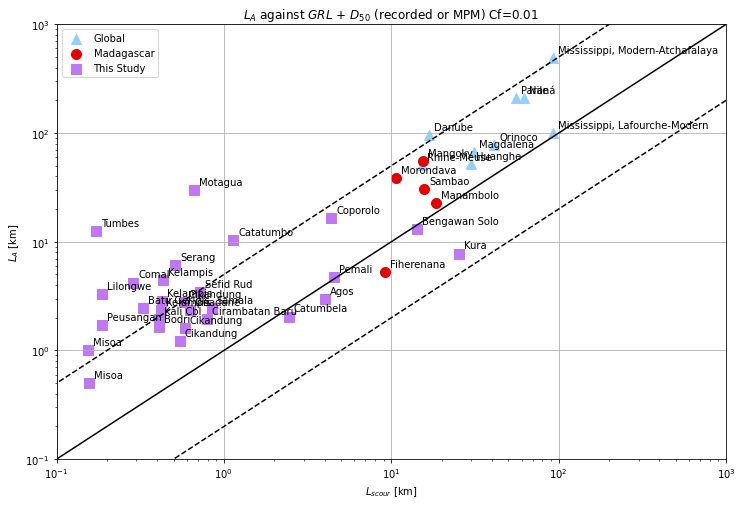

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# LA vs Lscour

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA_global = df['L_A [km]'][df['From'] == 'global']
Lscour_global = df['l_scour [km]'][df['From'] == 'global']

LA_mads = df['L_A [km]'][df['From'] == 'madagascar']
Lscour_mads = df['l_scour [km]'][df['From'] == 'madagascar']

LA_study = df['L_A [km]'][df['From'] == 'study']
Lscour_study = df['l_scour [km]'][df['From'] == 'study']

h1 = ax.scatter(Lscour_global, LA_global, s=100, marker='^', c='xkcd:light blue') 
h2 = ax.scatter(Lscour_mads, LA_mads, s=100, marker='o', c='xkcd:red') 
h3 = ax.scatter(Lscour_study, LA_study, s=100, marker='s', c='xkcd:light purple') 

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')
plt.legend([h1, h2, h3], ['Global', 'Madagascar', 'This Study'])
plt.grid('on')
ax.set_xlabel('$L_{scour}$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.1, top=1000)
ax.set_xlim(left=.1, right=1000)
plt.title('$L_A$ against $GRL$ + $D_{50}$ (recorded or MPM) Cf=0.01')

for idx, row in df.iterrows():
    ax.annotate(row.River, xy=(row['l_scour [km]'],row['L_A [km]']), xytext=(5, 5), xycoords='data', textcoords='offset points')
    

<ipython-input-4-5be72d3e0fa2>:7: MatplotlibDeprecationWarning: The 'nonposx' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale("log", nonposx='clip')
<ipython-input-4-5be72d3e0fa2>:8: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_yscale("log", nonposy='clip')


KeyError: 'Lscour [km] {GRL}'

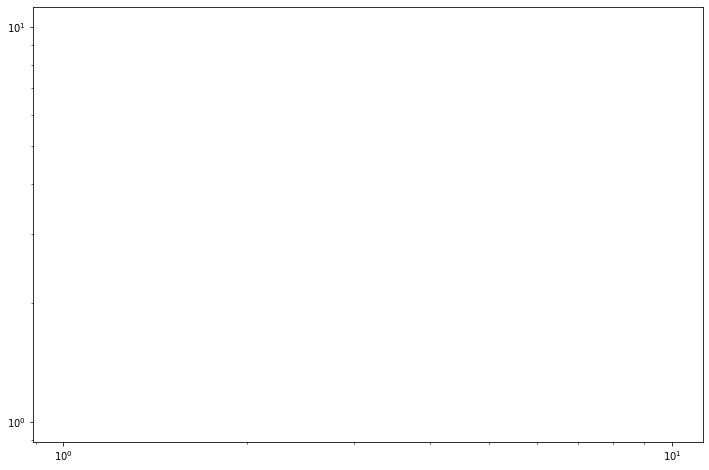

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# LA vs Lscour

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA_global = df['L_A [km]'][df['From'] == 'global']
Lscour_global = df['Lscour [km] {GRL}'][df['From'] == 'global']

LA_mads = df['L_A [km]'][df['From'] == 'madagascar']
Lscour_mads = df['Lscour [km] {GRL}'][df['From'] == 'madagascar']

LA_study = df['L_A [km]'][df['From'] == 'study']
Lscour_study = df['Lscour [km] {GRL}'][df['From'] == 'study']

h1 = ax.scatter(Lscour_global, LA_global, s=100, marker='^', c='xkcd:light blue') 
h2 = ax.scatter(Lscour_mads, LA_mads, s=100, marker='o', c='xkcd:red') 
h3 = ax.scatter(Lscour_study, LA_study, s=100, marker='s', c='xkcd:light purple') 

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')
plt.legend([h1, h2, h3], ['Global', 'Madagascar', 'This Study'])
plt.grid('on')
ax.set_xlabel('$L_{scour}$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.1, top=1000)
ax.set_xlim(left=.1, right=1000)
plt.title('$L_A$ against $L_{scour}$ - GRL (Using $D_{50}$)')

for idx, row in df.iterrows():
    ax.annotate(row.River, xy=(row['Lscour [km] {GRL}'],row['L_A [km]']), xytext=(5, 5), xycoords='data', textcoords='offset points')
    

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# LA vs Lscour

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA_global = global_avulsions['L_A [km]'][global_avulsions['From'] == 'global']
Lscour_global = global_avulsions['Lscour [km] {Ma}'][global_avulsions['From'] == 'global']

LA_mads = global_avulsions['L_A [km]'][global_avulsions['From'] == 'madagascar']
Lscour_mads = global_avulsions['Lscour [km] {Ma}'][global_avulsions['From'] == 'madagascar']

LA_study = global_avulsions['L_A [km]'][global_avulsions['From'] == 'study']
Lscour_study = global_avulsions['Lscour [km] {Ma}'][global_avulsions['From'] == 'study']

h1 = ax.scatter(Lscour_global, LA_global, s=100, marker='^', c='xkcd:light blue') 
h2 = ax.scatter(Lscour_mads, LA_mads, s=100, marker='o', c='xkcd:red') 
h3 = ax.scatter(Lscour_study, LA_study, s=100, marker='s', c='xkcd:light purple') 

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')
plt.legend([h1, h2, h3], ['Global', 'Madagascar', 'This Study'])
plt.grid('on')
ax.set_xlabel('$L_{scour}$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.1, top=1000)
ax.set_xlim(left=.1, right=1000)
plt.title('$L_A$ against $L_{scour}$ - Qs from Ma et al., (Using $D_{50}$)')

for idx, row in global_avulsions.iterrows():
    ax.annotate(row.River, xy=(row['Lscour [km] {Ma}'],row['L_A [km]']), xytext=(5, 5), xycoords='data', textcoords='offset points')
    

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# LA vs Lscour

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

has_recorded_D50 = global_avulsions['D50 [m] (recorded)']>0

global_avulsions_with_D50 = global_avulsions[has_recorded_D50]

LA_global = global_avulsions_with_D50['L_A [km]'][global_avulsions['From'] == 'global']
Lscour_global = global_avulsions_with_D50['Lscour [km] {best guess}'][global_avulsions['From'] == 'global']

LA_mads = global_avulsions_with_D50['L_A [km]'][global_avulsions['From'] == 'madagascar']
Lscour_mads = global_avulsions_with_D50['Lscour [km] {best guess}'][global_avulsions['From'] == 'madagascar']

LA_study = global_avulsions_with_D50['L_A [km]'][global_avulsions['From'] == 'study']
Lscour_study = global_avulsions_with_D50['Lscour [km] {best guess}'][global_avulsions['From'] == 'study']

h1 = ax.scatter(Lscour_global, LA_global, s=100, marker='^', c='xkcd:light blue') 
h2 = ax.scatter(Lscour_mads, LA_mads, s=100, marker='o', c='xkcd:red') 
h3 = ax.scatter(Lscour_study, LA_study, s=100, marker='s', c='xkcd:light purple') 

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')
plt.legend([h1, h2, h3], ['Global', 'Madagascar', 'This Study'])
plt.grid('on')
ax.set_xlabel('$L_{scour}$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.1, top=1000)
ax.set_xlim(left=.1, right=1000)
plt.title('$L_A$ against $L_{scour}$ - Using Best Guess')

for idx, row in global_avulsions_with_D50.iterrows():
    ax.annotate(row.River, xy=(row['Lscour [km] {best guess}'],row['L_A [km]']), xytext=(5, 5), xycoords='data', textcoords='offset points')
    

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# LA vs Lscour

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA = global_avulsions['L_A [km]']
Lscour = global_avulsions['Lscour [km] {best guess}']
slope = global_avulsions['S [-]']*100000

h1 = ax.scatter(Lscour, LA, s=slope, marker='^', c='xkcd:blue') 

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')
plt.legend([h1, h2, h3], ['Global', 'Madagascar', 'This Study'])
plt.grid('on')
ax.set_xlabel('$L_{scour}$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.1, top=1000)
ax.set_xlim(left=.1, right=1000)
plt.title('$L_A$ against $L_{scour}$ - With best guesses')

# for idx, row in global_avulsions.iterrows():
#     ax.annotate(row.River, xy=(row['Lscour [km] {best guess}'],row['L_A [km]']), xytext=(5, 5), xycoords='data', textcoords='offset points')
    

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# LA vs Lscour

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA = global_avulsions['L_A [km]']
Lscour = global_avulsions['Lscour [km] {best guess}']
cf = global_avulsions['Cf']*10000

h1 = ax.scatter(Lscour, LA, s=cf, marker='s', c='xkcd:red') 

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')
plt.grid('on')
ax.set_xlabel('$L_{scour}$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.1, top=1000)
ax.set_xlim(left=.1, right=1000)
plt.title('$L_A$ against $L_{scour}$ - With best guesses')


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# LA vs Lscour

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA = global_avulsions['L_A [km]']
Lscour = global_avulsions['Lscour [km] {best guess}']
cf = global_avulsions['Cf']*10000

h1 = ax.scatter(Lscour, LA, s=cf, marker='s', c='xkcd:red') 

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')
plt.grid('on')
ax.set_xlabel('$L_{scour}$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.1, top=1000)
ax.set_xlim(left=.1, right=1000)
plt.title('$L_A$ against $L_{scour}$ - With best guesses')


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# LA vs Lscour

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA = global_avulsions['L_A [km]']
Lscour = global_avulsions['Lscour [km] {best guess}']
cf = global_avulsions['D50 [m] (shields)']*10000

h1 = ax.scatter(Lscour, LA, s=cf, marker='s', c='xkcd:green', alpha=0.4) 

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')
plt.grid('on')
ax.set_xlabel('$L_{scour}$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.1, top=1000)
ax.set_xlim(left=.1, right=1000)
plt.title('$L_A$ against $L_{scour}$ - With best guesses')

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# LA vs Lscour

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

LA = global_avulsions['L_A [km]']
Lscour = global_avulsions['Lscour [km] {best guess}']
cf = global_avulsions['D50 [m] (1ms 50)']*1000000

h1 = ax.scatter(Lscour, LA, s=cf, marker='s', c='xkcd:brown', alpha=0.4) 

refplot = np.linspace(.01,1000,1000)
refplot_upper = refplot*5
refplot_lower = refplot/5
ax.plot(refplot,refplot, color='k')
ax.plot(refplot,refplot_upper, color='k', linestyle='dashed')
ax.plot(refplot, refplot_lower, color='k', linestyle='dashed')
plt.grid('on')
ax.set_xlabel('$L_{scour}$ [km]')
ax.set_ylabel('$L_A$ [km]')
ax.set_ylim(bottom=.1, top=1000)
ax.set_xlim(left=.1, right=1000)
plt.title('$L_A$ against $L_{scour}$ - With best guesses')